In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display="diagram")
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_roc_curve, auc,roc_curve,roc_auc_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')



In [7]:
df = pd.read_csv('Taz_Water.csv')

# Unnessary Columns for preditive model

In [8]:
pred_uncol = ['date_recorded','funder','installer','longitude','latitude','wpt_name','num_private','subvillage'
              ,'recorded_by','scheme_name','ward','public_meeting',
             'extraction_type','payment','quality_group','source_type','quantity',
             'waterpoint_type_group','permit']

In [9]:
pred_df = df.drop(pred_uncol,axis=1)
pred_df.head()

,id,amount_tsh,gps_height,basin,region,region_code,district_code,lga,population,scheme_management,...,extraction_type_class,management,management_group,payment_type,water_quality,quantity_group,source,source_class,waterpoint_type,status_group
0,69572,6000.0,1390,Lake Nyasa,Iringa,11,5,Ludewa,109,VWC,...,gravity,vwc,user-group,annually,soft,enough,spring,groundwater,communal standpipe,functional
1,8776,0.0,1399,Lake Victoria,Mara,20,2,Serengeti,280,Other,...,gravity,wug,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,34310,25.0,686,Pangani,Manyara,21,4,Simanjiro,250,VWC,...,gravity,vwc,user-group,per bucket,soft,enough,dam,surface,communal standpipe multiple,functional
3,67743,0.0,263,Ruvuma / Southern Coast,Mtwara,90,63,Nanyumbu,58,VWC,...,submersible,vwc,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,non functional
4,19728,0.0,0,Lake Victoria,Kagera,18,1,Karagwe,0,NaN,...,gravity,other,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,functional


# Setting target to binary

In [10]:
pred_df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [11]:
pred_df['status_group'] = pred_df['status_group'].replace('functional needs repair','functional')

In [12]:
pred_df['status_group'].value_counts()

functional        36576
non functional    22824
Name: status_group, dtype: int64

In [13]:
dd = pred_df.drop('id',axis=1)
dd.isna().sum()

amount_tsh                  0
gps_height                  0
basin                       0
region                      0
region_code                 0
district_code               0
lga                         0
population                  0
scheme_management        3877
construction_year           0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment_type                0
water_quality               0
quantity_group              0
source                      0
source_class                0
waterpoint_type             0
status_group                0
dtype: int64

# Train test split

In [14]:
X = dd.drop('status_group',axis=1)
y = dd['status_group']

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42,stratify=y)

# fixing the missing data

In [16]:
X_train["scheme_management"].fillna("VWC", inplace = True)
X_train['construction_year'] = X_train['construction_year'].replace(0,np.nan)
X_train['construction_year'] = X_train['construction_year'].apply(lambda x: x if pd.notnull(x) else np.random.randint(2000, 2010))

# Test

In [17]:
X_test["scheme_management"].fillna("VWC", inplace = True)
X_test['construction_year'] = X_test['construction_year'].replace(0,np.nan)
X_test['construction_year'] = X_test['construction_year'].apply(lambda x: x if pd.notnull(x) else np.random.randint(2000, 2010))

# Pipe lines

In [18]:
cat_cols = X_train.select_dtypes('object').columns
num_cols = X_train.select_dtypes(['int','float']).columns


numeric_pipe = Pipeline([('numnorm',StandardScaler())])

nominal_pipe = Pipeline([
    ('onehotenc', OneHotEncoder(sparse=False,handle_unknown = 'ignore')),
    ('onehotnorm', StandardScaler())
])

In [19]:
ct = ColumnTransformer([
    ('numpipe',numeric_pipe, num_cols),
    ('nominalpipe',nominal_pipe,cat_cols),
])
ct

ColumnTransformer(transformers=[('numpipe',
                                 Pipeline(steps=[('numnorm',
                                                  StandardScaler())]),
                                 Index(['amount_tsh', 'gps_height', 'region_code', 'district_code',
       'population', 'construction_year'],
      dtype='object')),
                                ('nominalpipe',
                                 Pipeline(steps=[('onehotenc',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False)),
                                                 ('onehotnorm',
                                                  StandardScaler())]),
                                 Index(['basin', 'region', 'lga', 'scheme_management', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'water_quality', 'quantity_group', 'source',
       'source_class', 'waterpoint_type'],
      dtype='object'))])

In [20]:
log = Pipeline([
    ('preprocess', ct),
    ("smote", SMOTE(random_state=42)),
    ('model',LogisticRegression(random_state=42))
])
log

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['amount_tsh', 'gps_height', 'region_code', 'district_code',
       'population', 'construction_year'],
      dtype='object')),
                                                 ('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('onehotnorm',
                                                                   StandardScaler())]),
                                                  Index(['basin', 'region', 'lga', 'scheme_management', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'water_quality', 'quantity_group', 'source',
       'source_class', 'waterpoint_type'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression(random_state=42))])

# Fit the Model

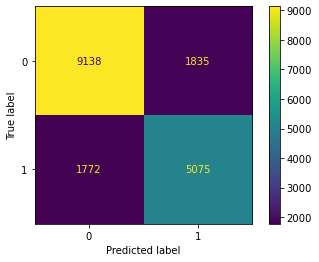

In [21]:
log.fit(X_train,y_train)
y_pred = log.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm
                              )
disp.plot();

In [22]:
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

    functional       0.84      0.83      0.84     10973
non functional       0.73      0.74      0.74      6847

      accuracy                           0.80     17820
     macro avg       0.79      0.79      0.79     17820
  weighted avg       0.80      0.80      0.80     17820



# Checking is overfitting

In [23]:
print(log.score(X_train,y_train))
print(log.score(X_test,y_test))

0.7973544973544974
0.7975869809203142


# AUC

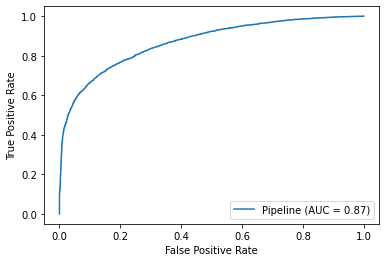

In [24]:
plot_roc_curve(log,X_test,y_test);

In [25]:
y_score = log.fit(X_train, y_train).predict_proba(X_test)
micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score[:, 1])

micro_roc_auc_ovr

0.8689356288855963

# Random Search

In [21]:
from sklearn.model_selection import RandomizedSearchCV
pipe_grid = dict()
pipe_grid['model__solver'] = ['lbfgs', 'liblinear']
pipe_grid['model__penalty'] = ['l1', 'l2']
pipe_grid['model__C'] = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]

In [22]:
pipe_grid

{'model__solver': ['lbfgs', 'liblinear'],
 'model__penalty': ['l1', 'l2'],
 'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [23]:
gs_pipe = RandomizedSearchCV(estimator=log,
                      param_distributions=pipe_grid, n_iter=16)
gs_pipe

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('numpipe',
                                                                               Pipeline(steps=[('numnorm',
                                                                                                StandardScaler())]),
                                                                               Index(['amount_tsh', 'gps_height', 'region_code', 'district_code',
       'population', 'construction_year'],
      dtype='object')),
                                                                              ('nominalpipe',
                                                                               Pipeline(steps=[('onehotenc',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              spars...
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'water_quality', 'quantity_group', 'source',
       'source_class', 'waterpoint_type'],
      dtype='object'))])),
                                             ('smote', SMOTE(random_state=42)),
                                             ('model',
                                              LogisticRegression(random_state=42))]),
                   n_iter=16,
                   param_distributions={'model__C': [0.0001, 0.001, 0.01, 0.1,
                                                     1, 10, 100, 1000],
                                        'model__penalty': ['l1', 'l2'],
                                        'model__solver': ['lbfgs',
                                                          'liblinear']})

In [24]:
# gs_pipe.fit(X_train,y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('numpipe',
                                                                               Pipeline(steps=[('numnorm',
                                                                                                StandardScaler())]),
                                                                               Index(['amount_tsh', 'gps_height', 'region_code', 'district_code',
       'population', 'construction_year'],
      dtype='object')),
                                                                              ('nominalpipe',
                                                                               Pipeline(steps=[('onehotenc',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              spars...
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'water_quality', 'quantity_group', 'source',
       'source_class', 'waterpoint_type'],
      dtype='object'))])),
                                             ('smote', SMOTE(random_state=42)),
                                             ('model',
                                              LogisticRegression(random_state=42))]),
                   n_iter=16,
                   param_distributions={'model__C': [0.0001, 0.001, 0.01, 0.1,
                                                     1, 10, 100, 1000],
                                        'model__penalty': ['l1', 'l2'],
                                        'model__solver': ['lbfgs',
                                                          'liblinear']})

In [25]:
gs_pipe.best_params_

{'model__solver': 'liblinear', 'model__penalty': 'l1', 'model__C': 0.01}

In [26]:
gs_pipe.best_score_

0.7955747955747956

In [ ]:
from joblib import dump, load
dump(gs_pipe.best_params_, 'log_best_params.joblib') 

In [4]:
from joblib import dump, load
clf = load('log_best_params.joblib')
clf

{'model__solver': 'liblinear', 'model__penalty': 'l1', 'model__C': 0.01}

# Best Model

In [29]:
best_model = Pipeline([
    ('preprocess', ct),
    ("smote", SMOTE(random_state=42)),
    ('model',LogisticRegression(random_state=42, solver = 'liblinear', penalty = 'l1', C = 0.01))
])
best_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['amount_tsh', 'gps_height', 'region_code', 'district_code',
       'population', 'construction_year'],
      dtype='object')),
                                                 ('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('onehotnorm',
                                                                   Stand...
                                                  Index(['basin', 'region', 'lga', 'scheme_management', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'water_quality', 'quantity_group', 'source',
       'source_class', 'waterpoint_type'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('model',
                 LogisticRegression(C=0.01, penalty='l1', random_state=42,
                                    solver='liblinear'))])

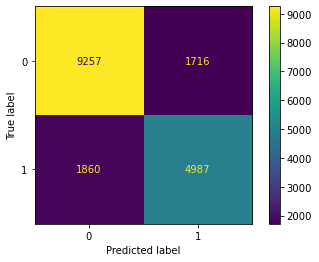

In [31]:
best_model.fit(X_train,y_train)
best_y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, best_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm
                              )
disp.plot();

# Best Model Accuracy

In [32]:
print(best_model.score(X_test,y_test))

0.7993265993265993


In [33]:
print(classification_report(y_test, best_y_pred))

                precision    recall  f1-score   support

    functional       0.83      0.84      0.84     10973
non functional       0.74      0.73      0.74      6847

      accuracy                           0.80     17820
     macro avg       0.79      0.79      0.79     17820
  weighted avg       0.80      0.80      0.80     17820



# Best Model AUC

In [34]:
best_y_score = best_model.fit(X_train, y_train).predict_proba(X_test)



best_micro_roc_auc_ovr = roc_auc_score(
    y_test,
    best_y_score[:,1],
)
best_micro_roc_auc_ovr

0.8672632152547357

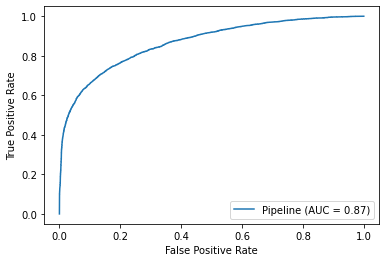

In [35]:
plot_roc_curve(best_model,X_test,y_test);